In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.io as sio
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter

In [94]:
X_train = pd.read_csv('data/umist_cropped.csv')

In [95]:
X_train.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
1    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
2    234.0    234.0    234.0    234.0    234.0    234.0    234.0    233.0   
3    234.0    234.0    234.0    234.0    233.0    230.0    225.0    109.0   
4    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_8  pixel_9  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    234.0    233.0  ...        195.0        195.0        193.0        192.0   
1    234.0    234.0  ...        192.0        192.0        191.0        186.0   
2    225.0    186.0  ...        192.0        192.0        191.0        185.0   
3     85.0     84.0  ...        180.0        174.0        168.0        164.0   
4    234.0    234.0  ...        192.0        192.0        191.0        190.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        192.0        192.0        192.0        191.0        190.0   
1        183.0        179.0        174.0        169.0        165.0   
2        184.0        177.0        170.0        166.0        164.0   
3        157.0        152.0        151.0        148.0        145.0   
4        188.0        184.0        177.0        173.0        168.0   

   pixel_10303  
0        191.0  
1        164.0  
2        163.0  
3        145.0  
4        164.0  

[5 rows x 10304 columns]

In [96]:
# Step 4: Normalize Data
scaler = StandardScaler() 
X_normalized = scaler.fit_transform(X_train)

In [97]:
# Step 6: Dimensionality Reduction with PCA
pca = PCA(0.95) 
X_train_pca = pca.fit_transform(X_train)

In [98]:
print(f"Original Dimensionality: {X_train.shape[1]}, Reduced Dimensionality: {X_train_pca.shape[1]}")

Original Dimensionality: 10304, Reduced Dimensionality: 128


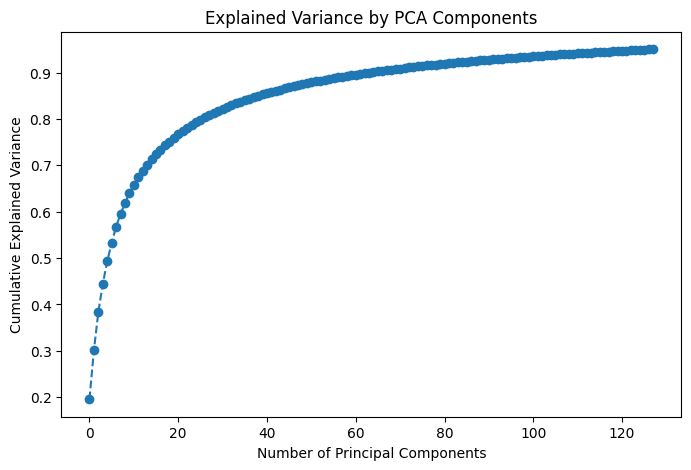

In [99]:
# Visualize explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.show()

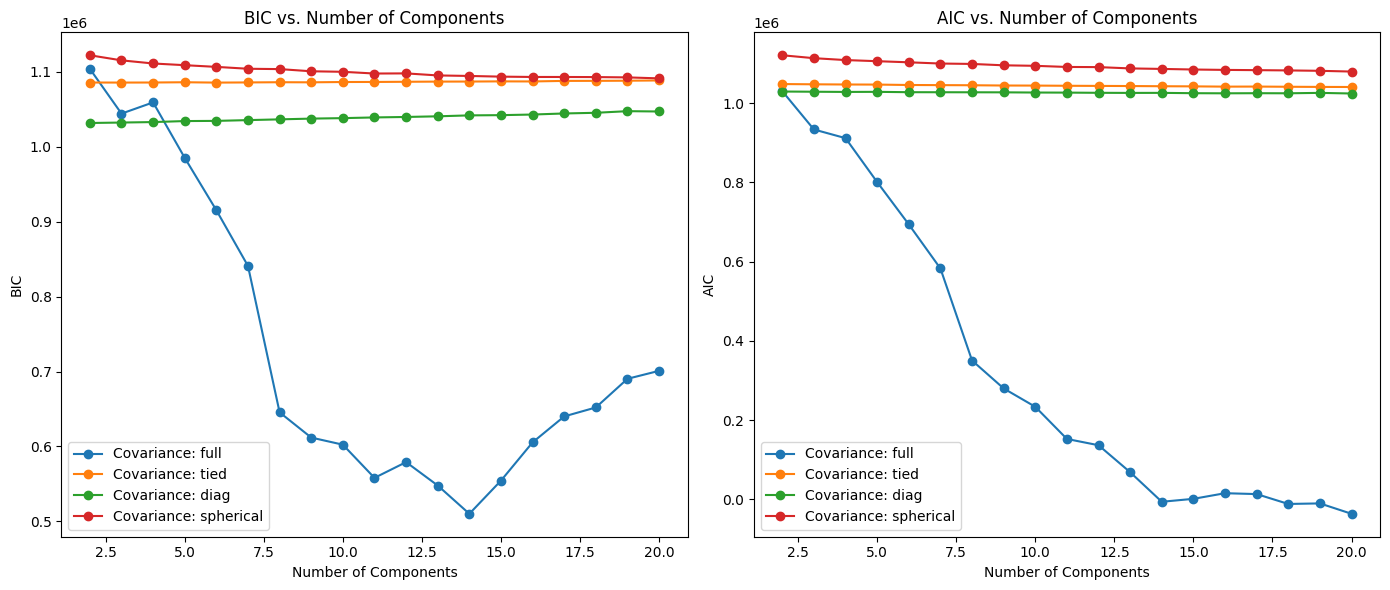

Best GMM model has 14 components and covariance type: full


In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Step 7: Grid Search for Optimal GMM Parameters (n_components and covariance_type)
def grid_search_gmm(X_train_pca):
    # Define the parameter grid for GMM
    param_grid = {
        'n_components': range(2, 21),  # Test for 2 to 20 components
        'covariance_type': ['full', 'tied', 'diag', 'spherical']  # Different covariance types
    }

    # Initialize the GMM with default parameters
    gmm = GaussianMixture(random_state=42)
    
    # Initialize variables to store best model and evaluation metrics
    best_model = None
    best_score = -1  # Silhouette score should be maximized
    best_bic = np.inf
    best_aic = np.inf
    
    # Store BIC and AIC for plotting
    bic_scores = {'full': [], 'tied': [], 'diag': [], 'spherical': []}
    aic_scores = {'full': [], 'tied': [], 'diag': [], 'spherical': []}
    
    # Iterate through the parameter grid
    for n_components in param_grid['n_components']:
        for cov_type in param_grid['covariance_type']:
            gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
            gmm.fit(X_train_pca)

            # Calculate BIC and AIC
            bic = gmm.bic(X_train_pca)
            aic = gmm.aic(X_train_pca)

            # Predict clusters
            clusters = gmm.predict(X_train_pca)

            # Calculate silhouette score
            silhouette = silhouette_score(X_train_pca, clusters)

            # Compare BIC and AIC scores and silhouette score
            if bic < best_bic or (bic == best_bic and silhouette > best_score):
                best_bic = bic
                best_aic = aic
                best_score = silhouette
                best_model = gmm

            # Store BIC and AIC for plotting
            bic_scores[cov_type].append(bic)
            aic_scores[cov_type].append(aic)

    # Plot BIC and AIC scores for each covariance type
    plt.figure(figsize=(14, 6))

    # Plot BIC scores
    plt.subplot(1, 2, 1)
    for cov_type in param_grid['covariance_type']:
        plt.plot(param_grid['n_components'], bic_scores[cov_type], marker='o', label=f'Covariance: {cov_type}')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.title('BIC vs. Number of Components')
    plt.legend()

    # Plot AIC scores
    plt.subplot(1, 2, 2)
    for cov_type in param_grid['covariance_type']:
        plt.plot(param_grid['n_components'], aic_scores[cov_type], marker='o', label=f'Covariance: {cov_type}')
    plt.xlabel('Number of Components')
    plt.ylabel('AIC')
    plt.title('AIC vs. Number of Components')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return the best model found
    return best_model

# Perform grid search for the best GMM model
best_gmm = grid_search_gmm(X_train_pca)

# Output best GMM parameters
print(f"Best GMM model has {best_gmm.n_components} components and covariance type: {best_gmm.covariance_type}")

In [101]:
# Predict clusters for evaluation
train_clusters = best_gmm.predict(X_train_pca)

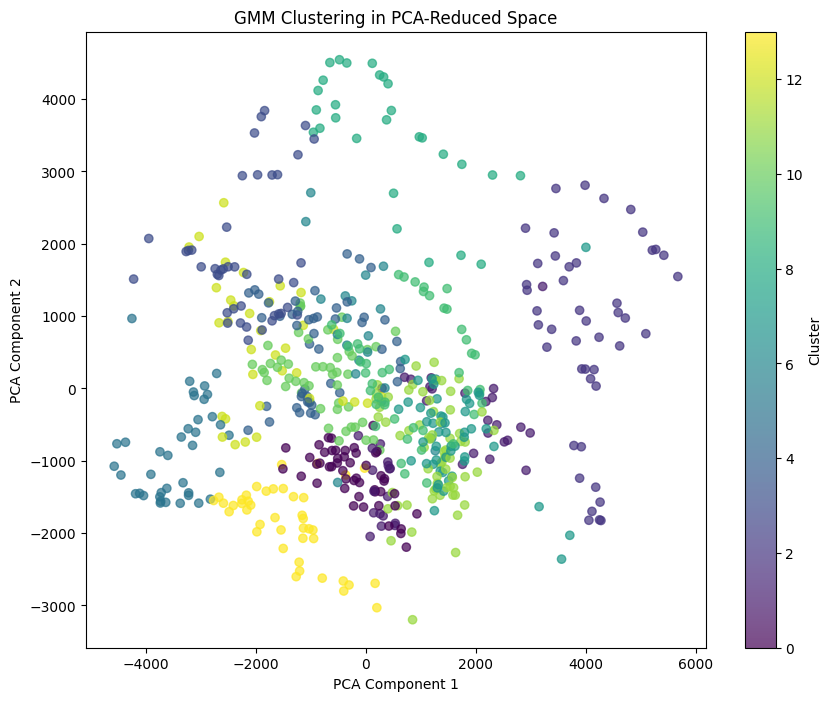

In [102]:
# Visualize clusters in PCA space
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("GMM Clustering in PCA-Reduced Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [103]:
# Step 11: Evaluate Clusters
sil_score = silhouette_score(X_train_pca, train_clusters)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.11454498058681803


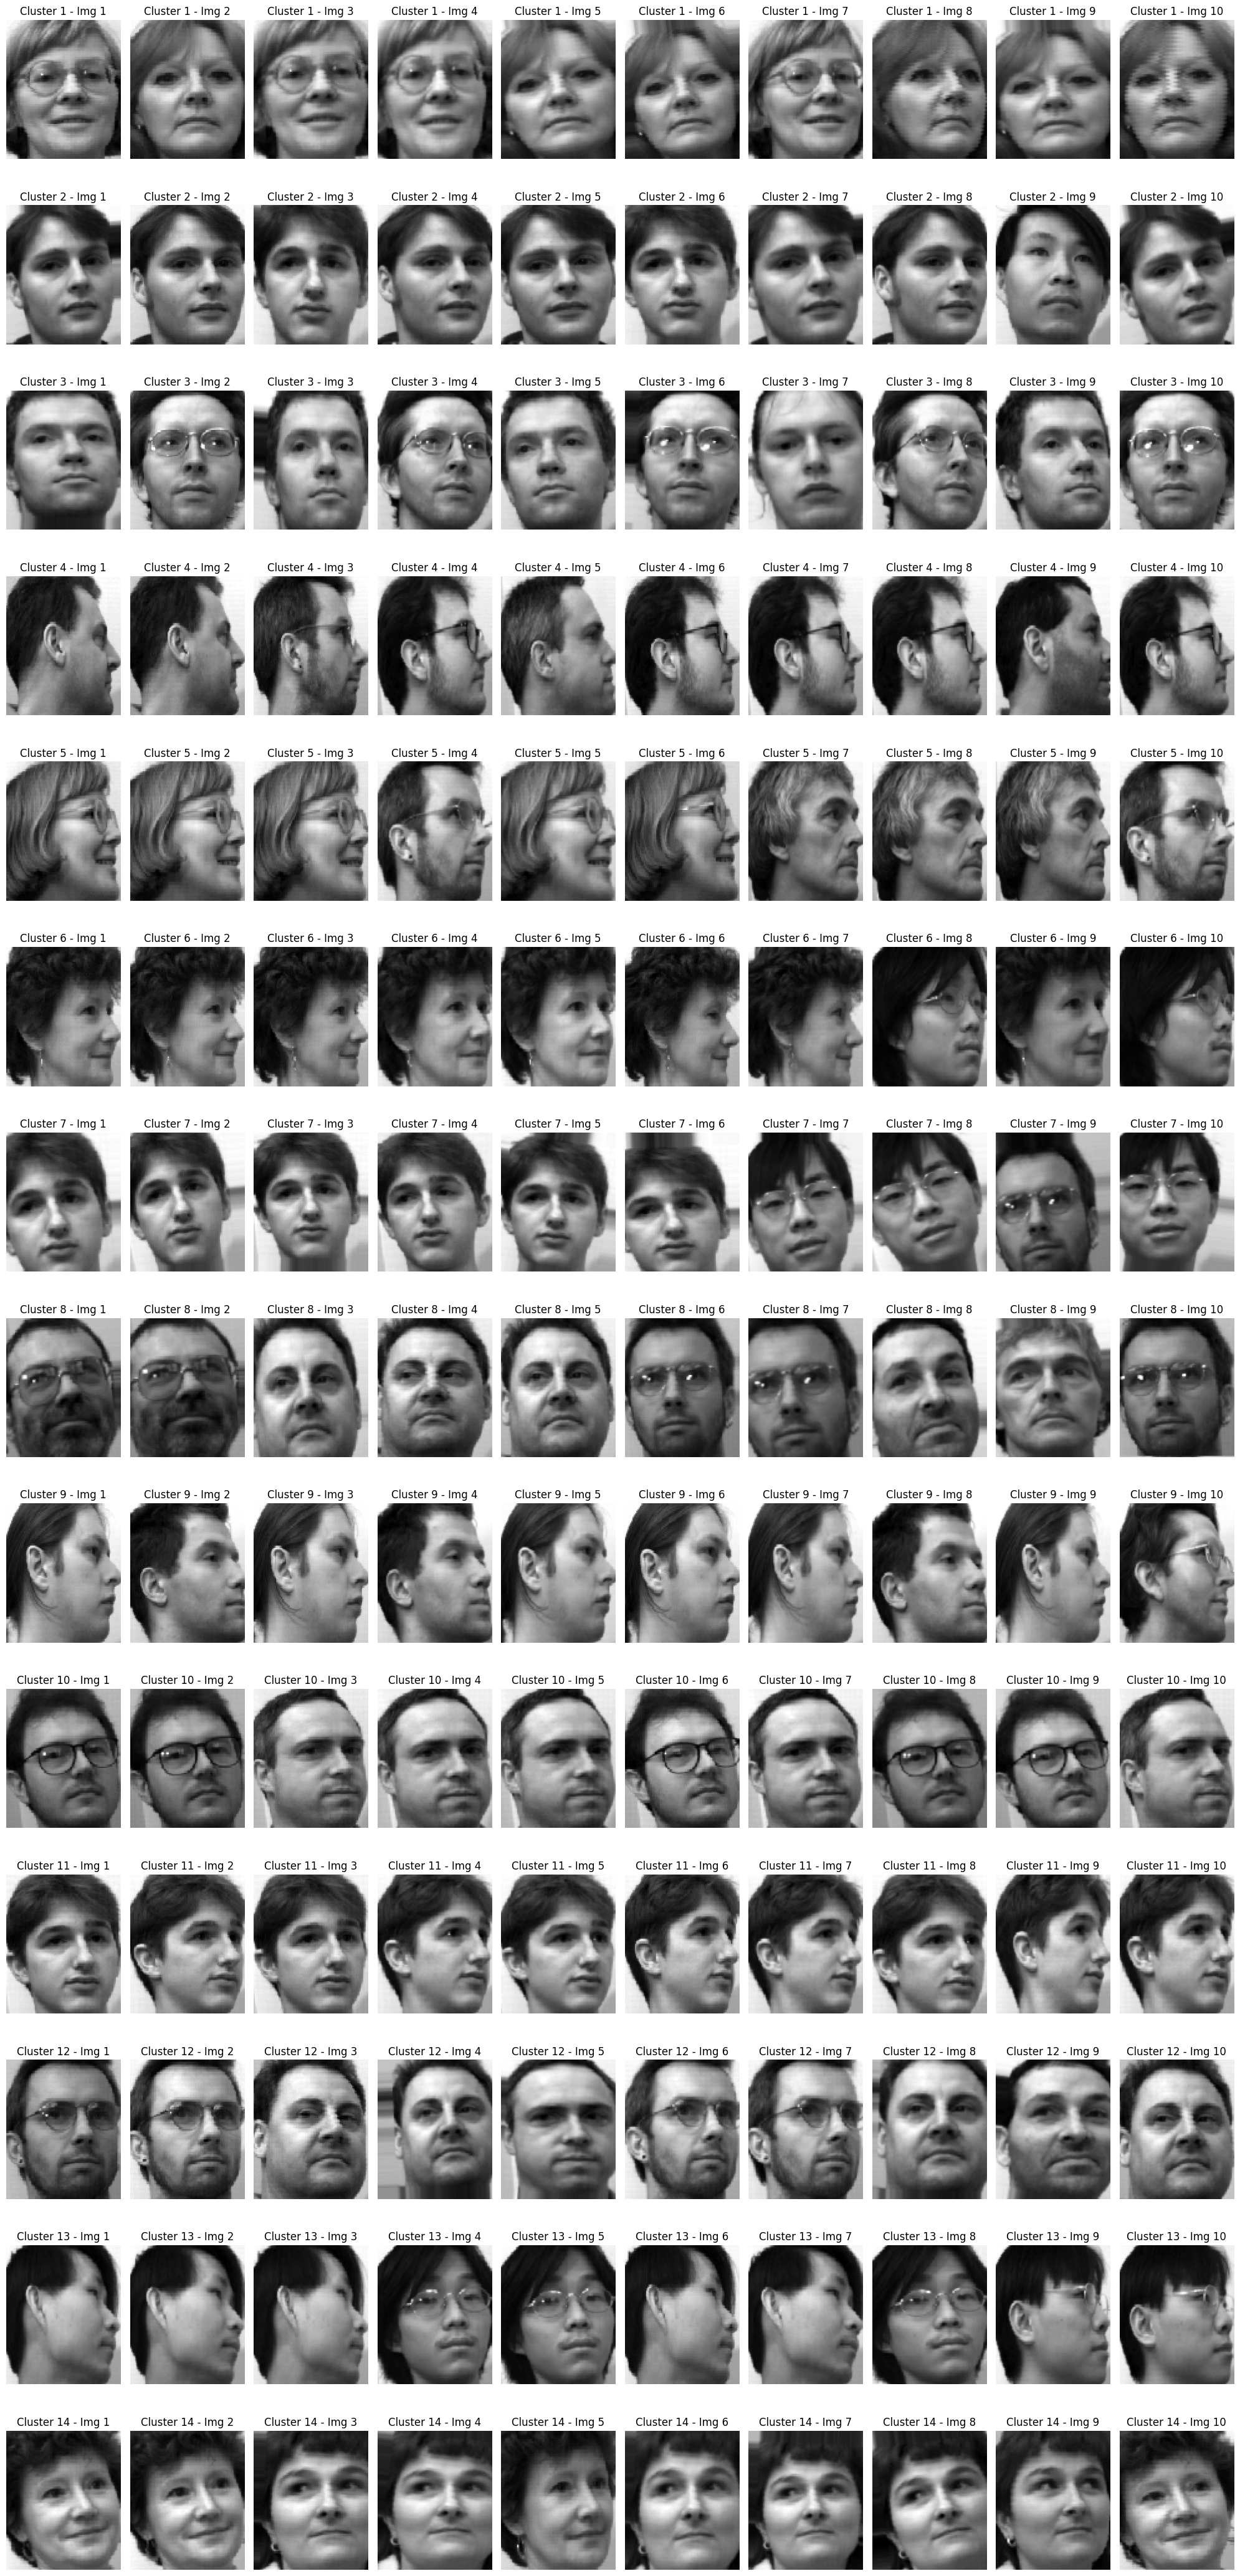

In [104]:
def visualize_closest_images_per_cluster(gmm, X_pca, X_original, n_images_per_cluster=10):
    # Predict cluster labels for all images
    cluster_labels = gmm.predict(X_pca)
    
    num_clusters = gmm.n_components
    rows = 2  # To visualize images in a row-wise format
    cols = n_images_per_cluster  # Number of images to display per cluster
    
    plt.figure(figsize=(cols * 2, rows * num_clusters * 1.5))
    
    # For each cluster, find the closest images and display them
    for cluster_idx in range(num_clusters):
        # Get the indices of the images belonging to this cluster
        cluster_indices = np.where(cluster_labels == cluster_idx)[0]
        
        # Compute the distances between all images in the cluster and the cluster center
        cluster_center = gmm.means_[cluster_idx]
        distances = euclidean_distances(X_pca[cluster_indices], [cluster_center])
        
        # Get the indices of the n_images_per_cluster closest images to the cluster center
        closest_indices = cluster_indices[np.argsort(distances.flatten())[:n_images_per_cluster]]
        
        # Display these closest images
        for i, img_idx in enumerate(closest_indices):
            # If X_original is a DataFrame, use `.iloc` to access rows by index
            if isinstance(X_original, pd.DataFrame):
                image = X_original.iloc[img_idx].values.reshape(112, 92)  # Reshape the flattened image
            else:
                image = X_original[img_idx].reshape(112, 92)  # Reshape the flattened image if it's an array
            
            plt.subplot(num_clusters, cols, cluster_idx * cols + i + 1)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.title(f"Cluster {cluster_idx + 1} - Img {i + 1}")
    
    plt.tight_layout()
    plt.show()

# Visualize the closest images for each cluster
visualize_closest_images_per_cluster(best_gmm, X_train_pca, X_train, n_images_per_cluster=10)


In [105]:
# Plot the distribution of each cluster
original_data = pd.read_csv("data/umist_with_original_face_id.csv")

In [106]:
original_data['cluster_id'] = train_clusters

In [107]:
original_labels = original_data['label']
clustered_labels = original_data['cluster_id']

In [108]:
unique_labels = np.unique(original_labels)
unique_clustered_labels = np.unique(clustered_labels)

original_labels = original_labels.to_numpy()
clustered_labels = clustered_labels.to_numpy()

In [109]:
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 10 else ''

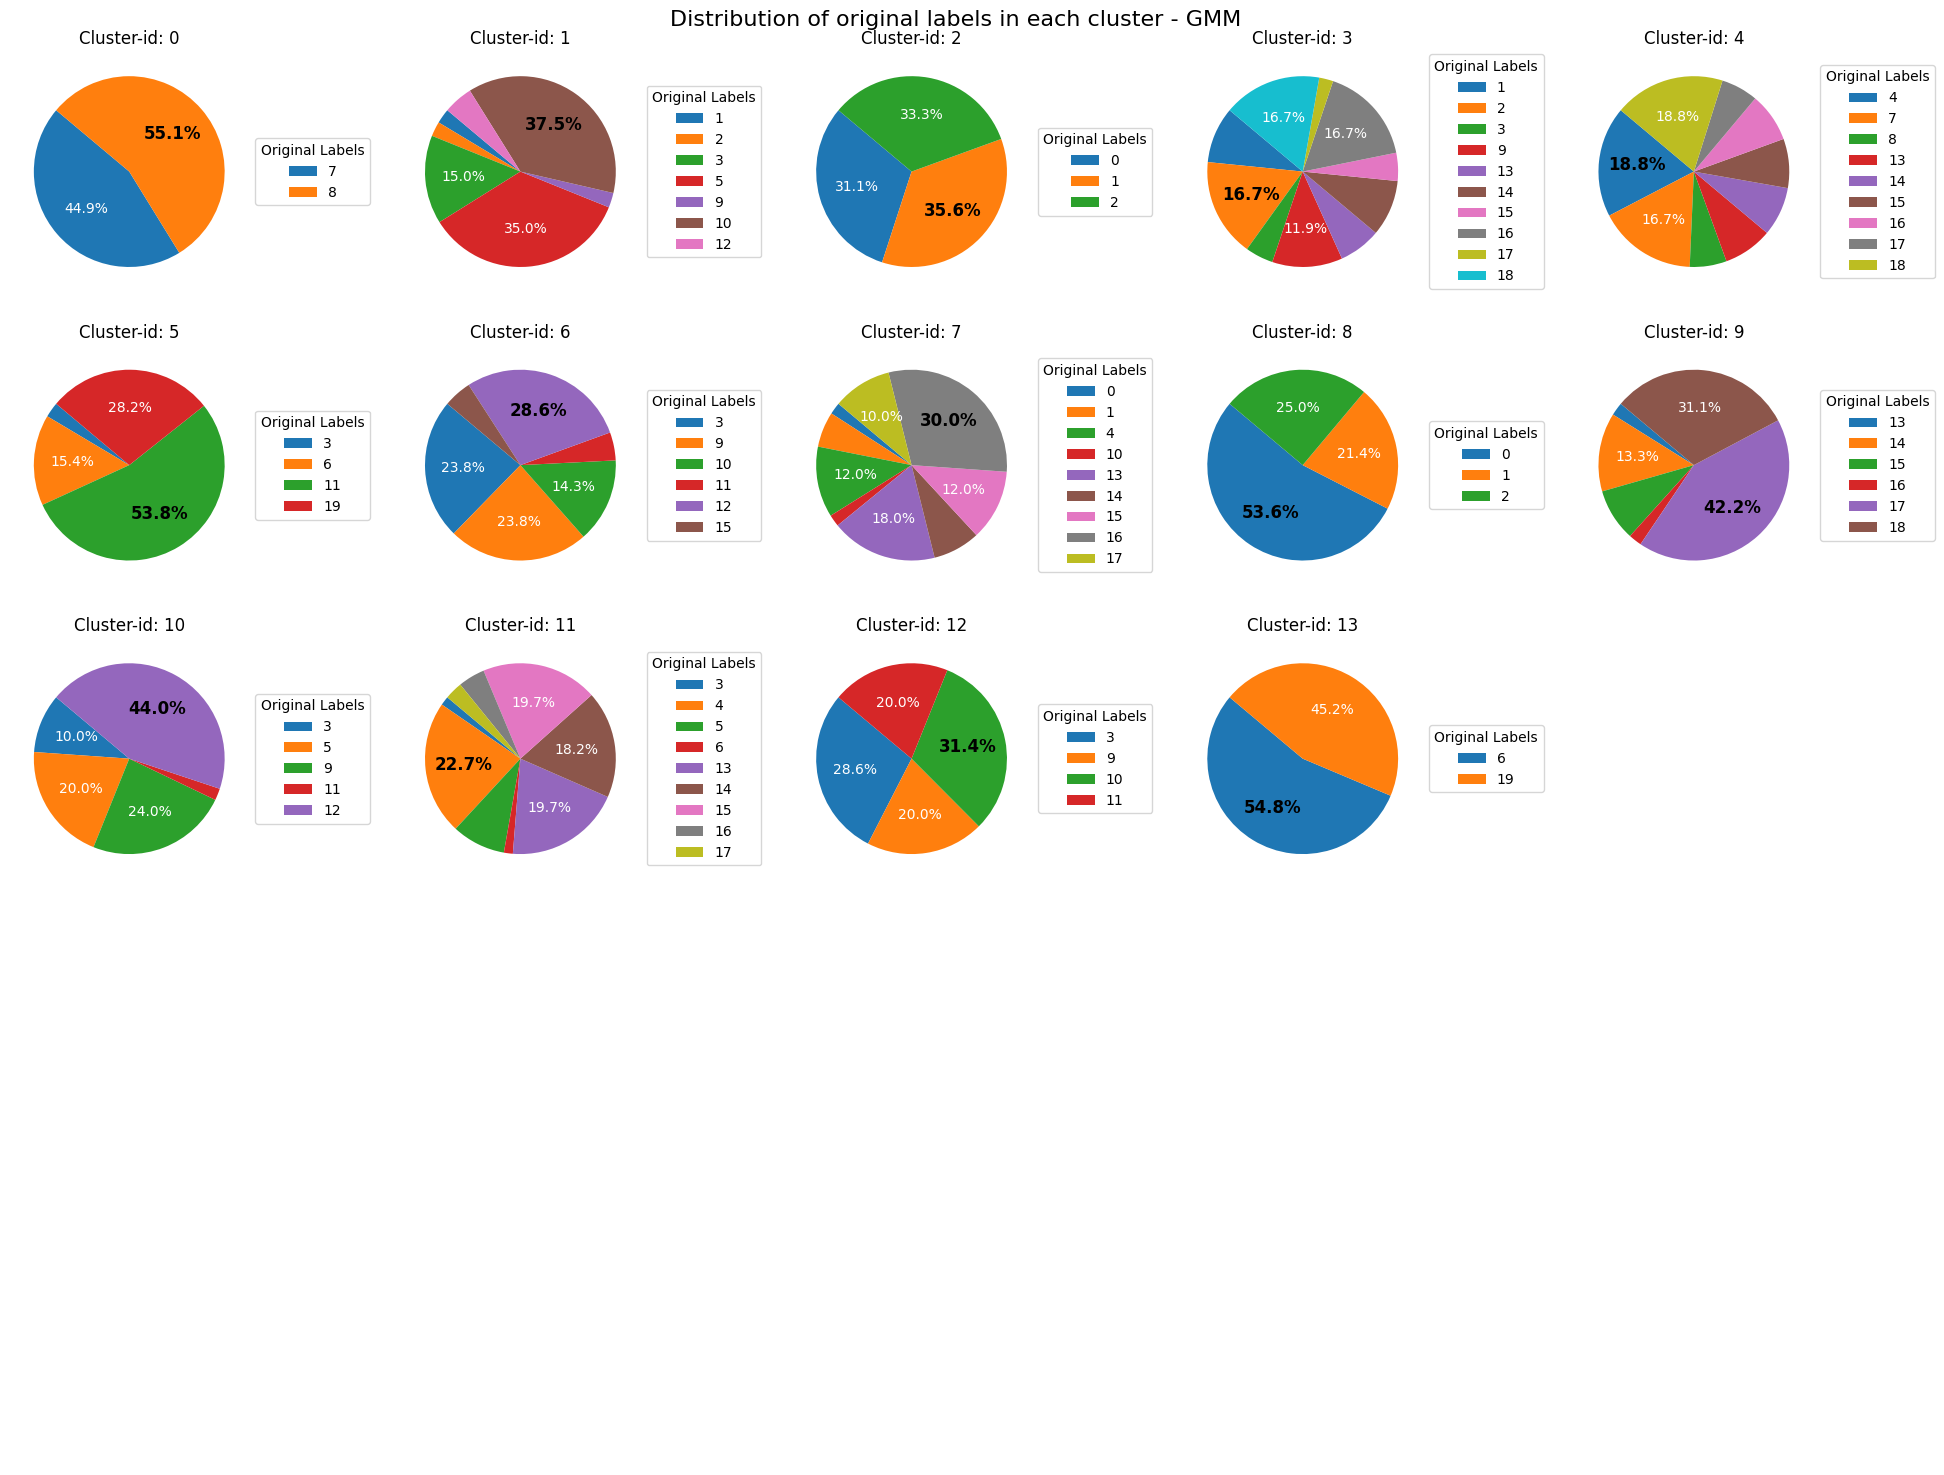

In [113]:
df = pd.DataFrame({'Original Labels': original_labels, 'Clustered Labels': clustered_labels})

num_clusters = len(unique_clustered_labels)
fig, axes = plt.subplots(5, 5, figsize=(20, 15), subplot_kw=dict(aspect="equal"))

axes = axes.flatten()

for i, cluster in enumerate(unique_clustered_labels):
    cluster_data = df[df['Clustered Labels'] == cluster]
    cluster_original_labels = cluster_data['Original Labels']
    
    cluster_original_labels_count = Counter(cluster_original_labels)
    labels = list(cluster_original_labels_count.keys())
    counts = list(cluster_original_labels_count.values())
    
    wedges, texts, autotexts = axes[i].pie(counts, labels=labels, autopct=lambda pct: autopct_format(pct), textprops=dict(color="w"), startangle=140)
    
    axes[i].legend(wedges, labels, title='Original Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    largest_pct_idx = np.argmax(counts)
    autotexts[largest_pct_idx].set_color('black')
    autotexts[largest_pct_idx].set_fontsize(12)
    autotexts[largest_pct_idx].set_fontweight('bold')
        
    axes[i].set_title(f'Cluster-id: {cluster}')
        
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
        
plt.suptitle('Distribution of original labels in each cluster - GMM', fontsize=16)
plt.tight_layout()
plt.show()